<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_dedalus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the diffusion equation with Dedalus

**Overview:** This notebook solves the diffusion equation using a spectral method and provides an introduction to Dedalus.

**About Dedalus:** [Dedalus](http://dedalus-project.org) is an open-source Python package for solving partial differential equations (PDEs) using spectral methods.
These methods provide highly accurate numerical solutions for PDEs with smooth solutions in simple domains like boxes and spheres.
Dedalus implements modern parallel algorithms utilizing sparse polynomial bases, but all with an easy-to-use symbolic interface.
The code is being used in a wide range of fields, often for problems involving fluid dynamics.

This script is based in part on the Introduction to Dedalus by [Keaton Burns](http://keaton-burns.com)

The student exercise starts in [Section 5](#student_investigation)

# 1. Setup

First, we need to install Dedalus.  If you are running Python on your local computer, follow the install instructions in the [Dedalus Docs](https://dedalus-project.readthedocs.io/en/latest/pages/installation.html) to install Dedalus locally on your computer.

The cell below checks to see if Dedalus is installed.  After installing Dedalus, run the cell below to verify that Dedalus is installed correctly.

If you are using Google Colab, the cell below will automatically install Dedalus.

This cell checks if Dedalus is installed and performs some other basic setup. This will take some time the first time you run it.

Once you have Dedalus installed, you won't need to run this cell again.

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

At the start of each Python script, we need to import the packages that we will use.  The cell below imports the packages that will be needed here, namely numpy, matplotlib (for plotting) and dedalus. Note that we assign aliases for numpy, matplotlib, and dedlaus. Run this cell before running any of the cells below.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

## 2. Dedalus basics

Dedalus solves PDEs using spectral methods.  Dedalus requires us to specify the spatial coordinates, the `distributor`, and the spectral bases, which are explained below.

### Coordinates

We can use a variety of coordinate systems in Dedalus. For example, for multi-dimensional problems, we can use Cartesian coordinates, polar coordinates, spherical coordinates, etc. Here, we will set up a 1D problem using the Dedalus `Coordinate` class. We will see other examples in future projects.
For more details on other problem types, included distributed parallel simulations, see the official [Dedalus Tutorial 1](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_1.html).

Let's create a coordinate object representing our 1D coordinate, which here we will call `x`:

In [3]:
xcoord = dedalus.Coordinate('x')

### Distributors

Dedalus uses MPI (Message Passing Interface) for allow parallel computation on distributed memory systems. There are various options for how to distribute the computation amongst the processes. In Dedalus this is done by an object called a `Distributor`. Here, we will run not run in paralle, but Dedalus still requies us to create a `Distributor` object. You don't need to worry about this now, we will discuss it further in later projects.

The line below creates a distributor for our x coordinate for a problem with real variables.

In [4]:
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization

### Spectral basis

Dedalus decomposes the PDE that we are solving using a spectral basis. Dedalus has the ability to use different basis functions for this decomposition, and this gives Dedalus remarkable flexibility. For example, `RealFourier` provides a Fouier basis (sine and cosine functions) can be used for problems that are periodic (cyclic) in physical space. The `Chebyshev` basis allows boundary conditions to be set on a finite interval. The `SphereBasis` allows us to solve problems on a sphere.

The line below creates a Fourier basis for a real-valued system with a domain size of Lx=10 and with Nx=1024 gridpoints in physical space.

In [5]:
# Set some parameters
Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
x_start=-1; x_end=1 # The starting and ending bounds on x

# Construct a Fourier basis
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))

### Grids

Each basis has a corresponding grid in physical space that can be used for tasks like initializing and plotting fields.

The line below creates a grid for the x coordinate.


In [6]:
x = dist.local_grid(x_basis)

### Fields

`Field` objects in Dedalus represent scalar-valued fields defined over a set of bases (or a "domain").
For multidimensional problems, vector and tensor valued fields can also be constructed using the `VectorField` and `TensorField` clases.

Let's construct a field called `c` (for concentration) using our 1D basis:

In [7]:
c = dist.Field(name='c', bases=x_basis)

Field objects have internal methods for transforming their data between grid (`'g'`) and coefficeint (`'c'`) space representations.
The field's values can be assigned and retrieved by indexing a field with these strings.

Let's set the grid-space values of our field, `c`, to be a Gaussian function of `x`. This is how we set the initial condition for the initial value problem that we will solve below.

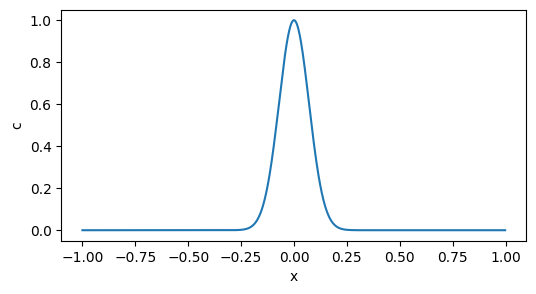

In [8]:
w = 0.1 # Set the width of the initial Gaussian
c.change_scales(1) # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

plt.figure(figsize=(6, 3)) # Set the size of the figure
plt.plot(x, c['g']) # Plot the "grid-space" initial conditions
plt.xlabel('x'); plt.ylabel("c"); # Set the axis labels

As a bit of an aside, we can find the coefficients of the spectral representation of a field using ['c'] instead of ['g'].
This triggers an in-place spectral (in this case Fourier) transform of the field's data.
For the `RealFourier` basis, the coefficients are the interleaved real-valued coefficients of the cosine and (negative) sine coefficients.
For very large problems transforming between grid and coefficient space will be time-consuming, so you will want to limit the number of times that this is done.

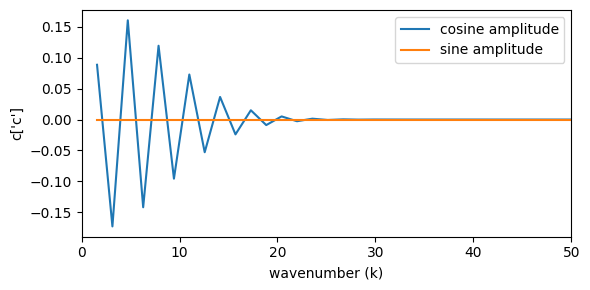

In [9]:
k = np.pi * np.arange(1, Nx/2+1) / (x_end - x_start) # Create an array of wavenumbers, k(i)=i*pi/Lx
plt.figure(figsize=(6, 3))
plt.plot(k, c['c'][0::2], label='cosine amplitude')
plt.plot(k, -c['c'][1::2], label='sine amplitude')
plt.xlabel('wavenumber (k)')
plt.ylabel("c['c']")
plt.xlim(0, 50)
plt.legend()
plt.tight_layout()

## 3. Problems and Solvers

Dedalus uses Problem and Solver classes to specify the problem and the methods that will be used to solve it. Here, we will set up the diffusion equation and solve it using the Crank-Nicolson timestepping method.

For more details on other problem types, see [Dedalus Tutorial 3](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_2.html).

### Problems

Dedalus standardizes the formulation of all initial value problems by taking systems of symbolically specified equations and boundary conditions specified in the following generic form:

$$\mathcal{M} \cdot \partial_t \mathcal{X} + \mathcal{L} \cdot \mathcal{X} = \mathcal{F}(\mathcal{X}, t)$$

where $\mathcal{M}$ and $\mathcal{L}$ are matrices of linear differential operators, $\mathcal{X}$ is a state vector of the unknown fields, $\mathcal{F}$ is a vector of general nonlinear expressions.

The left-hand side (LHS) of the equations must be first-order in temporal derivatives and linear in the problem variables.
The right-hand side (RHS) of the equations may contain nonlinear and time-dependent terms, but no temporal derivatives.

When using a mixed implicit/explicit timestepping scheme, Dedalus will apply the implicit method to the $\mathcal{L}\cdot \mathcal{X}$ term and the explicit method to the $\mathcal{F}(\mathcal{X}, t)$ term.

To create a problem object, we provide a list of the variables to be solved for. In this case, this is just `c`.

Equations can then be entered as pairs of operator expressions like `(LHS, RHS)` or as strings like `"LHS = RHS"`.

Here, let's set up the diffusion equation:

$$\partial_t c - \kappa \partial_x^2 c = 0$$

Note that we put the term with the second derivative on the left hand side of the equation so that it will be time-stepped implicitly.

In [10]:
# Parameters
kappa = 0.001

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

# Specify the problem
problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
problem.add_equation("dt(c) - kappa*dx(dx(c)) = 0"); # Write out the equation to be solved


### 3.2 Solvers

Now, we need to specify the solver.  For IVPs, we specify a timestepping method when building the solver. Below we select the `CNAB1` timestepper which uses Crank-Nicolson for the $\mathcal{L}\cdot \mathcal{X}$ term and the explicit first order Adams-Bashforth method for the right hand side term (but in this case the RHS is zero).

In [11]:
timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


2024-12-16 09:33:31,841 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


Next, we need to specify a condition for the simulation to end. This can be a set number of iterations (set using `solver.stop_iteration`), a stopping time in simulation time units (set using `solver.stop_sim_time`, or a maximum wall clock time in seconds (set using `solver.stop_wall_time`).



In [12]:
solver.stop_sim_time = 10 # Stop at 10 simulation time units

IVPs are iterated using the `solver.step` method with a provided timestep.
The logic controlling the main-loop of a Dedalus IVP simulation occurs explicitly in the simulation script.
The `solver.proceed` property will change from `True` to `False` once any of the specified stopping criteria have been met.
Let's timestep our problem until the halting condition is reached, copying the grid values of `u` every few iterations.
This should take just a few seconds to run.

In [13]:
# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0: # Every 500 timesteps, print a message to the screen with the progress
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    # save the values of c and t
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

INFO:solvers:Simulation stop time reached.


2024-12-16 09:33:31,927 solvers 0/1 INFO :: Simulation stop time reached.


Now we can make a space-time plot of the solution:

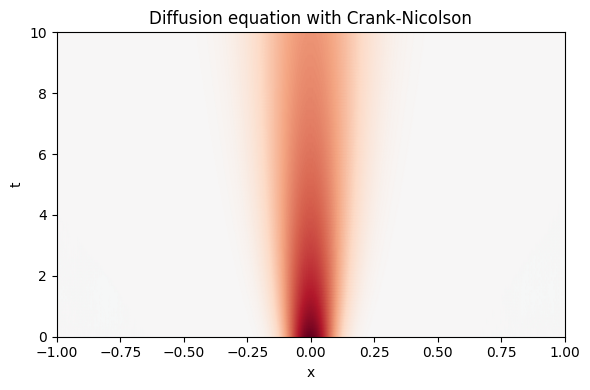

In [14]:
# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_save), np.array(c_save), cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-1, 1))
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'Diffusion equation with Crank-Nicolson')
plt.tight_layout()

## 4. Forced diffusion equation

Dedalus is extremely flexible, which will make it very useful throughout the QCES computational projects. For example, it is relatively straightforward to change the equation that we are solving.

In order to introduce functions into the equations that Dedalus solves, we need to define a new operator.  For example, the following code defines the function $sin(x)$ on our grid:

In [15]:
# Create an operator that applies a function to the variable on a grid
sin_x = dist.Field(bases=x_basis)
sin_x['g'] = np.sin(x)

The code below uses Dedlaus to solve the forced diffusion equation:

$$\partial_t c - \kappa \partial_x^2 c = cos(\pi x / Lx)$$

with the same Gaussian initial condition as before. This example also shows what a complete Dedalus script looks like.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.2e+00/s


2024-12-16 09:33:34,023 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.2e+00/s


INFO:solvers:Simulation stop time reached.


2024-12-16 09:33:34,226 solvers 0/1 INFO :: Simulation stop time reached.


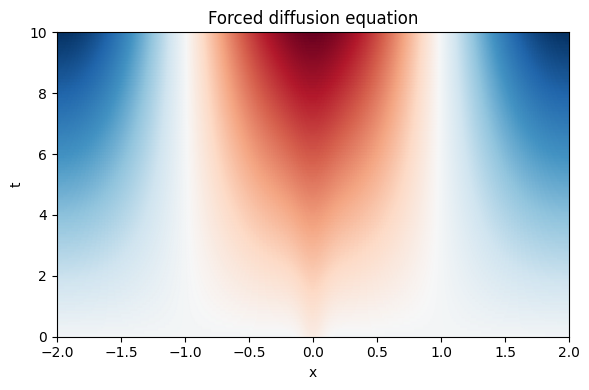

In [16]:
# Load the required packages (these were loaded above and are inluded here for completeness)
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# This script solves the forced diffusion equation with Dedlaus

# Set some parameters for the problem to be solved
Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
Lx = 2; # The domain size in x.  This should be large enough so that the solution goes to zero at the endpoints.
x_start=-Lx; x_end=Lx # The starting and ending bounds on x
kappa = 0.001 # set the diffusivity

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)

# Set initial conditions
c = dist.Field(name='c', bases=x_basis)
w = 0.1 # Set the width of the initial Gaussian
c.change_scales(1) # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

# Create an operator that applies a function to the variable on a grid
f_x = dist.Field(bases=x_basis)
f_x['g'] = np.cos(np.pi * x / Lx)

# Specify the problem
problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
problem.add_equation("dt(c) - kappa * dx(dx(c)) = f_x"); # Write out the equation to be solved

timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

solver.stop_sim_time = 10 # Stop at 10 simulation time units

# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0: # Every 500 timesteps, print a message to the screen with the progress
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_save), np.array(c_save), cmap='RdBu_r', shading='gouraud', rasterized=True)#, clim=(-1, 1))
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Forced diffusion equation')
plt.tight_layout()

## 5. Student investigation
<a id='student_investigation'></a>

### 5.1 Steady-state solution to the forced diffusion equation

For the forced diffusion equation described in section 4, using dimensional analysis, estimate the time needed to reach a steady-state solution. Test this scaling, and discuss your results below. Run the code above for a sufficient time to achieve a steady-state solution. Plot $c$ at the end of this simulation, and compare it with the exact steady-state solution to the forced diffusion equation.

Students should comment on the timescale needed to transition from the initial condition to the forced solution, and comment on the diffusive and forcing timescales.

The time needed to reach a steady-state solution can be derived as follows using scaling analysis. Let $$c = c^{*} \times C,$$ $$t = t^{*} \times T,$$ $$\kappa = \kappa^{*} \times K$$ and $$x = x^{*} \times L,$$ where $c^{*}$, $t^{*}$, $\kappa^{*}$ and $x^{*}$ are numbers and $C$, $T$, $K$ and $L$ are units, i.e., dimensions. From the forced diffusion equation, we know $$\frac{C}{T} \sim K*\frac{C}{L^{2}},$$ i.e., $$T \sim \frac{L^{2}}{K}.$$ Therefore, the time needed to reach a steady-state solution is $t = \frac{2^2}{0.001} = 4,000$.

To test if $t=4,000$ is truly the time needed for the system to reach equilibrium, I plotted below a graph of the concentrations at $x=0$ over time, and it seems that around $t=4,000$, the system reaches equilibrium.

The exact steady-state solution, $c(x, t)$, to the forced equation given above, can be derived as follows.
1. As it is in the steady state, $\frac{\partial C}{\partial t}=0$, resulting in a new equation: $$-\kappa \frac{\partial^2C}{{\partial x}^2}=cos(\frac{\pi x}{L_x}).$$
2. Integrating this equation with respect to $x$ gives $$c=\frac{{L_x}^2}{\kappa {\pi}^2} \times cos(\frac{\pi x}{L_x}) + f(t)x + g(t).$$
3. We know $$\frac{\partial C}{\partial t}=-\frac{L_x}{\kappa \pi} \times sin(\frac{\pi x}{L_x}) + f'(t)x + g'(t)=0$$ for all $x$ and all $t$ ($t>4,000$). First, at a specific $t$ ($t>4,000$), $$-\frac{L_x}{\kappa \pi} \times sin(\frac{\pi x}{L_x}) + f'(t)x + g'(t)=0$$ for all $x$. As the first term of this equation varies between $-\frac{L_x}{\kappa \pi}$ and $\frac{L_x}{\kappa \pi}$, $f'(t)=0$. Thus, $f(t)=C_1$, where $C_1$ is a constant number. Additionally, $$-\frac{L_x}{\kappa \pi} \times sin(\frac{\pi x}{L_x}) + g'(t)=0$$ should remain true at a specific $x$ for all $t$ ($t>4,000$). Thus, $$g'(t)=\frac{L_x}{\kappa \pi} \times sin(\frac{\pi x}{L_x})$$ and $$g(t)=\frac{L_x}{\kappa \pi} \times t \times sin(\frac{\pi x}{L_x})$$.
4. From 1 to 3, we now know $$c=\frac{{L_x}^2}{\kappa {\pi}^2} \times cos(\frac{\pi x}{L_x}) + C_1x + \frac{L_x}{\kappa \pi} \times t \times sin(\frac{\pi x}{L_x})$$ at the steady state.
5. The only $x$ where we can compare the values calculated from Dedalus and those from the exact solution is $x=0$, as we have no more clue to get the value of $C_1$. Using the exact solution yields $$ c|_{x=0, t=4,000}=\frac{2^2}{0.001*{\pi}^2} \sim 405.28. $$
Using the Dedalus code given above to calculate $c$ at $x=0, t=4,000$ (see below) gives $$ c|_{x=0, t=4,000}\sim 405.31. $$
Therefore, we can conclude Dedalus is more or less accurate in getting the exact solution to a PDE.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-12-16 09:49:04,996 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


INFO:__main__:Iteration=500, Time=5.000000e+01, dt=1.000000e-01


2024-12-16 09:49:05,257 __main__ 0/1 INFO :: Iteration=500, Time=5.000000e+01, dt=1.000000e-01


INFO:__main__:Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


2024-12-16 09:49:05,533 __main__ 0/1 INFO :: Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


2024-12-16 09:49:05,781 __main__ 0/1 INFO :: Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


2024-12-16 09:49:06,043 __main__ 0/1 INFO :: Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


2024-12-16 09:49:06,297 __main__ 0/1 INFO :: Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


2024-12-16 09:49:06,570 __main__ 0/1 INFO :: Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


2024-12-16 09:49:06,728 __main__ 0/1 INFO :: Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


2024-12-16 09:49:06,902 __main__ 0/1 INFO :: Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


2024-12-16 09:49:07,054 __main__ 0/1 INFO :: Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


2024-12-16 09:49:07,210 __main__ 0/1 INFO :: Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


2024-12-16 09:49:07,370 __main__ 0/1 INFO :: Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


2024-12-16 09:49:07,537 __main__ 0/1 INFO :: Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


2024-12-16 09:49:07,704 __main__ 0/1 INFO :: Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


2024-12-16 09:49:07,872 __main__ 0/1 INFO :: Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


2024-12-16 09:49:08,042 __main__ 0/1 INFO :: Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


2024-12-16 09:49:08,204 __main__ 0/1 INFO :: Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


2024-12-16 09:49:08,360 __main__ 0/1 INFO :: Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


2024-12-16 09:49:08,519 __main__ 0/1 INFO :: Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


2024-12-16 09:49:08,726 __main__ 0/1 INFO :: Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


2024-12-16 09:49:08,902 __main__ 0/1 INFO :: Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


2024-12-16 09:49:09,064 __main__ 0/1 INFO :: Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


2024-12-16 09:49:09,223 __main__ 0/1 INFO :: Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


2024-12-16 09:49:09,378 __main__ 0/1 INFO :: Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


2024-12-16 09:49:09,539 __main__ 0/1 INFO :: Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


2024-12-16 09:49:09,707 __main__ 0/1 INFO :: Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


2024-12-16 09:49:09,877 __main__ 0/1 INFO :: Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


2024-12-16 09:49:10,050 __main__ 0/1 INFO :: Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


2024-12-16 09:49:10,210 __main__ 0/1 INFO :: Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


2024-12-16 09:49:10,363 __main__ 0/1 INFO :: Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


2024-12-16 09:49:10,511 __main__ 0/1 INFO :: Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


2024-12-16 09:49:10,673 __main__ 0/1 INFO :: Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


2024-12-16 09:49:10,849 __main__ 0/1 INFO :: Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


2024-12-16 09:49:11,016 __main__ 0/1 INFO :: Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


2024-12-16 09:49:11,175 __main__ 0/1 INFO :: Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


2024-12-16 09:49:11,332 __main__ 0/1 INFO :: Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


2024-12-16 09:49:11,489 __main__ 0/1 INFO :: Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


2024-12-16 09:49:11,651 __main__ 0/1 INFO :: Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


2024-12-16 09:49:11,817 __main__ 0/1 INFO :: Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


2024-12-16 09:49:12,000 __main__ 0/1 INFO :: Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


2024-12-16 09:49:12,161 __main__ 0/1 INFO :: Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


2024-12-16 09:49:12,322 __main__ 0/1 INFO :: Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


2024-12-16 09:49:12,477 __main__ 0/1 INFO :: Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


2024-12-16 09:49:12,636 __main__ 0/1 INFO :: Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


2024-12-16 09:49:12,802 __main__ 0/1 INFO :: Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


2024-12-16 09:49:12,984 __main__ 0/1 INFO :: Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


2024-12-16 09:49:13,151 __main__ 0/1 INFO :: Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


2024-12-16 09:49:13,302 __main__ 0/1 INFO :: Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


2024-12-16 09:49:13,462 __main__ 0/1 INFO :: Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


2024-12-16 09:49:13,622 __main__ 0/1 INFO :: Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


2024-12-16 09:49:13,778 __main__ 0/1 INFO :: Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


2024-12-16 09:49:13,969 __main__ 0/1 INFO :: Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


2024-12-16 09:49:14,132 __main__ 0/1 INFO :: Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


2024-12-16 09:49:14,291 __main__ 0/1 INFO :: Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


2024-12-16 09:49:14,449 __main__ 0/1 INFO :: Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


2024-12-16 09:49:14,608 __main__ 0/1 INFO :: Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


2024-12-16 09:49:14,759 __main__ 0/1 INFO :: Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


2024-12-16 09:49:14,964 __main__ 0/1 INFO :: Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


2024-12-16 09:49:15,126 __main__ 0/1 INFO :: Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


2024-12-16 09:49:15,291 __main__ 0/1 INFO :: Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


2024-12-16 09:49:15,446 __main__ 0/1 INFO :: Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


2024-12-16 09:49:15,606 __main__ 0/1 INFO :: Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


2024-12-16 09:49:15,762 __main__ 0/1 INFO :: Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


2024-12-16 09:49:15,953 __main__ 0/1 INFO :: Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


2024-12-16 09:49:16,119 __main__ 0/1 INFO :: Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


2024-12-16 09:49:16,281 __main__ 0/1 INFO :: Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


2024-12-16 09:49:16,438 __main__ 0/1 INFO :: Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


2024-12-16 09:49:16,619 __main__ 0/1 INFO :: Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


2024-12-16 09:49:16,880 __main__ 0/1 INFO :: Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


2024-12-16 09:49:17,156 __main__ 0/1 INFO :: Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


2024-12-16 09:49:17,390 __main__ 0/1 INFO :: Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


2024-12-16 09:49:17,622 __main__ 0/1 INFO :: Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


2024-12-16 09:49:17,847 __main__ 0/1 INFO :: Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


2024-12-16 09:49:18,099 __main__ 0/1 INFO :: Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


2024-12-16 09:49:18,332 __main__ 0/1 INFO :: Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


2024-12-16 09:49:18,557 __main__ 0/1 INFO :: Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


2024-12-16 09:49:18,819 __main__ 0/1 INFO :: Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


2024-12-16 09:49:19,092 __main__ 0/1 INFO :: Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


2024-12-16 09:49:19,365 __main__ 0/1 INFO :: Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


2024-12-16 09:49:20,046 __main__ 0/1 INFO :: Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


2024-12-16 09:49:20,318 __main__ 0/1 INFO :: Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=40500, Time=4.050000e+03, dt=1.000000e-01


2024-12-16 09:49:20,565 __main__ 0/1 INFO :: Iteration=40500, Time=4.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=41000, Time=4.100000e+03, dt=1.000000e-01


2024-12-16 09:49:20,723 __main__ 0/1 INFO :: Iteration=41000, Time=4.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=41500, Time=4.150000e+03, dt=1.000000e-01


2024-12-16 09:49:20,888 __main__ 0/1 INFO :: Iteration=41500, Time=4.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=42000, Time=4.200000e+03, dt=1.000000e-01


2024-12-16 09:49:21,046 __main__ 0/1 INFO :: Iteration=42000, Time=4.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=42500, Time=4.250000e+03, dt=1.000000e-01


2024-12-16 09:49:21,219 __main__ 0/1 INFO :: Iteration=42500, Time=4.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=43000, Time=4.300000e+03, dt=1.000000e-01


2024-12-16 09:49:21,379 __main__ 0/1 INFO :: Iteration=43000, Time=4.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=43500, Time=4.350000e+03, dt=1.000000e-01


2024-12-16 09:49:21,535 __main__ 0/1 INFO :: Iteration=43500, Time=4.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=44000, Time=4.400000e+03, dt=1.000000e-01


2024-12-16 09:49:21,689 __main__ 0/1 INFO :: Iteration=44000, Time=4.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=44500, Time=4.450000e+03, dt=1.000000e-01


2024-12-16 09:49:21,850 __main__ 0/1 INFO :: Iteration=44500, Time=4.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=45000, Time=4.500000e+03, dt=1.000000e-01


2024-12-16 09:49:22,033 __main__ 0/1 INFO :: Iteration=45000, Time=4.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=45500, Time=4.550000e+03, dt=1.000000e-01


2024-12-16 09:49:22,212 __main__ 0/1 INFO :: Iteration=45500, Time=4.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=46000, Time=4.600000e+03, dt=1.000000e-01


2024-12-16 09:49:22,368 __main__ 0/1 INFO :: Iteration=46000, Time=4.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=46500, Time=4.650000e+03, dt=1.000000e-01


2024-12-16 09:49:22,520 __main__ 0/1 INFO :: Iteration=46500, Time=4.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=47000, Time=4.700000e+03, dt=1.000000e-01


2024-12-16 09:49:22,680 __main__ 0/1 INFO :: Iteration=47000, Time=4.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=47500, Time=4.750000e+03, dt=1.000000e-01


2024-12-16 09:49:22,842 __main__ 0/1 INFO :: Iteration=47500, Time=4.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=48000, Time=4.800000e+03, dt=1.000000e-01


2024-12-16 09:49:23,023 __main__ 0/1 INFO :: Iteration=48000, Time=4.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=48500, Time=4.850000e+03, dt=1.000000e-01


2024-12-16 09:49:23,185 __main__ 0/1 INFO :: Iteration=48500, Time=4.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=49000, Time=4.900000e+03, dt=1.000000e-01


2024-12-16 09:49:23,356 __main__ 0/1 INFO :: Iteration=49000, Time=4.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=49500, Time=4.950000e+03, dt=1.000000e-01


2024-12-16 09:49:23,518 __main__ 0/1 INFO :: Iteration=49500, Time=4.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=50000, Time=5.000000e+03, dt=1.000000e-01


2024-12-16 09:49:23,680 __main__ 0/1 INFO :: Iteration=50000, Time=5.000000e+03, dt=1.000000e-01


INFO:solvers:Simulation stop time reached.


2024-12-16 09:49:23,685 solvers 0/1 INFO :: Simulation stop time reached.


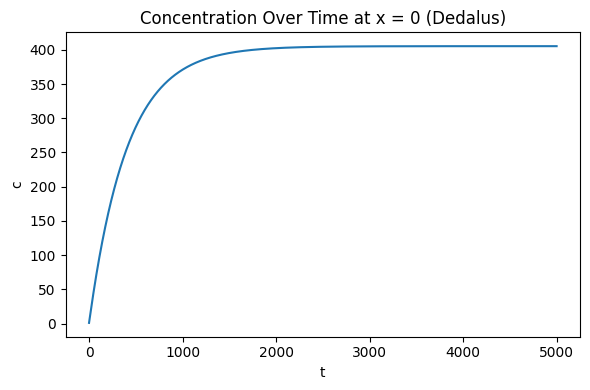

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging

# Dedalus
c_save = []
t_save = []
logger = logging.getLogger(__name__)
Nx = 1024
Lx = 2
kappa = 0.001
x_start=-Lx; x_end=Lx
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64)
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)
c = dist.Field(name='c', bases=x_basis)
w = 0.1
c.change_scales(1)
c['g'] = np.exp(-x**2/w**2)
dx = lambda a: dedalus.Differentiate(a, xcoord)
f_x = dist.Field(bases=x_basis)
f_x['g'] = np.cos(np.pi * x / Lx)
problem = dedalus.IVP([c], namespace=locals())
problem.add_equation("dt(c) - kappa * dx(dx(c)) = f_x")
timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)
solver.stop_sim_time = 5000
timestep = 0.1
c.change_scales(1)
x_focus = 0
x_focus_grid = np.argmin(np.abs(x-x_focus))
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    c.change_scales(1)
    c_save.append(c['g'][x_focus_grid])
    t_save.append(solver.sim_time)
c_save = np.array(c_save)
t_save = np.array(t_save)

plt.figure(figsize=(6, 4))
plt.plot(t_save, c_save)
plt.xlabel('t')
plt.ylabel('c')
plt.title('Concentration Over Time at x = 0 (Dedalus)')
plt.tight_layout()
plt.show()

In [25]:
t_target = 4000
t_idx = np.argmin(np.abs(t_save - t_target))

c_at_x_0_t_4000 = c_save[t_idx]

print(f"The concentration at t = 4,000 and x = 0 is approximately {c_at_x_0_t_4000:.2f}.")

The concentration at t = 4,000 and x = 0 is approximately 405.31.


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+01/s


2024-12-16 09:48:01,063 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+01/s


INFO:__main__:Iteration=500, Time=5.000000e+01, dt=1.000000e-01


2024-12-16 09:48:01,367 __main__ 0/1 INFO :: Iteration=500, Time=5.000000e+01, dt=1.000000e-01


INFO:__main__:Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


2024-12-16 09:48:01,669 __main__ 0/1 INFO :: Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


2024-12-16 09:48:01,953 __main__ 0/1 INFO :: Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


2024-12-16 09:48:02,266 __main__ 0/1 INFO :: Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


2024-12-16 09:48:02,446 __main__ 0/1 INFO :: Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


2024-12-16 09:48:02,618 __main__ 0/1 INFO :: Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


2024-12-16 09:48:02,813 __main__ 0/1 INFO :: Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


2024-12-16 09:48:03,007 __main__ 0/1 INFO :: Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


2024-12-16 09:48:03,179 __main__ 0/1 INFO :: Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


2024-12-16 09:48:03,359 __main__ 0/1 INFO :: Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


2024-12-16 09:48:03,531 __main__ 0/1 INFO :: Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


2024-12-16 09:48:03,717 __main__ 0/1 INFO :: Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


2024-12-16 09:48:03,907 __main__ 0/1 INFO :: Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


2024-12-16 09:48:04,083 __main__ 0/1 INFO :: Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


2024-12-16 09:48:04,267 __main__ 0/1 INFO :: Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


2024-12-16 09:48:04,445 __main__ 0/1 INFO :: Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


2024-12-16 09:48:04,626 __main__ 0/1 INFO :: Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


2024-12-16 09:48:04,804 __main__ 0/1 INFO :: Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


2024-12-16 09:48:04,986 __main__ 0/1 INFO :: Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


2024-12-16 09:48:05,158 __main__ 0/1 INFO :: Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


2024-12-16 09:48:05,325 __main__ 0/1 INFO :: Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


2024-12-16 09:48:05,482 __main__ 0/1 INFO :: Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


2024-12-16 09:48:05,656 __main__ 0/1 INFO :: Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


2024-12-16 09:48:05,850 __main__ 0/1 INFO :: Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


2024-12-16 09:48:06,027 __main__ 0/1 INFO :: Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


2024-12-16 09:48:06,186 __main__ 0/1 INFO :: Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


2024-12-16 09:48:06,358 __main__ 0/1 INFO :: Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


2024-12-16 09:48:06,532 __main__ 0/1 INFO :: Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


2024-12-16 09:48:06,688 __main__ 0/1 INFO :: Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


2024-12-16 09:48:06,878 __main__ 0/1 INFO :: Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


2024-12-16 09:48:07,050 __main__ 0/1 INFO :: Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


2024-12-16 09:48:07,212 __main__ 0/1 INFO :: Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


2024-12-16 09:48:07,376 __main__ 0/1 INFO :: Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


2024-12-16 09:48:07,548 __main__ 0/1 INFO :: Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


2024-12-16 09:48:07,714 __main__ 0/1 INFO :: Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


2024-12-16 09:48:07,910 __main__ 0/1 INFO :: Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


2024-12-16 09:48:08,071 __main__ 0/1 INFO :: Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


2024-12-16 09:48:08,243 __main__ 0/1 INFO :: Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


2024-12-16 09:48:08,410 __main__ 0/1 INFO :: Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


2024-12-16 09:48:08,592 __main__ 0/1 INFO :: Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


2024-12-16 09:48:08,748 __main__ 0/1 INFO :: Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


2024-12-16 09:48:08,941 __main__ 0/1 INFO :: Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


2024-12-16 09:48:09,114 __main__ 0/1 INFO :: Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


2024-12-16 09:48:09,273 __main__ 0/1 INFO :: Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


2024-12-16 09:48:09,438 __main__ 0/1 INFO :: Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


2024-12-16 09:48:09,602 __main__ 0/1 INFO :: Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


2024-12-16 09:48:09,765 __main__ 0/1 INFO :: Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


2024-12-16 09:48:09,974 __main__ 0/1 INFO :: Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


2024-12-16 09:48:10,142 __main__ 0/1 INFO :: Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


2024-12-16 09:48:10,322 __main__ 0/1 INFO :: Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


2024-12-16 09:48:10,488 __main__ 0/1 INFO :: Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


2024-12-16 09:48:10,660 __main__ 0/1 INFO :: Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


2024-12-16 09:48:10,828 __main__ 0/1 INFO :: Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


2024-12-16 09:48:11,028 __main__ 0/1 INFO :: Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


2024-12-16 09:48:11,206 __main__ 0/1 INFO :: Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


2024-12-16 09:48:11,383 __main__ 0/1 INFO :: Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


2024-12-16 09:48:11,552 __main__ 0/1 INFO :: Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


2024-12-16 09:48:11,717 __main__ 0/1 INFO :: Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


2024-12-16 09:48:11,925 __main__ 0/1 INFO :: Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


2024-12-16 09:48:12,122 __main__ 0/1 INFO :: Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


2024-12-16 09:48:12,309 __main__ 0/1 INFO :: Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


2024-12-16 09:48:12,590 __main__ 0/1 INFO :: Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


2024-12-16 09:48:12,867 __main__ 0/1 INFO :: Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


2024-12-16 09:48:13,143 __main__ 0/1 INFO :: Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


2024-12-16 09:48:13,398 __main__ 0/1 INFO :: Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


2024-12-16 09:48:13,652 __main__ 0/1 INFO :: Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


2024-12-16 09:48:14,276 __main__ 0/1 INFO :: Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


2024-12-16 09:48:14,851 __main__ 0/1 INFO :: Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


2024-12-16 09:48:15,145 __main__ 0/1 INFO :: Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


2024-12-16 09:48:15,431 __main__ 0/1 INFO :: Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


2024-12-16 09:48:15,731 __main__ 0/1 INFO :: Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


2024-12-16 09:48:16,013 __main__ 0/1 INFO :: Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


2024-12-16 09:48:16,215 __main__ 0/1 INFO :: Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


2024-12-16 09:48:16,397 __main__ 0/1 INFO :: Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


2024-12-16 09:48:16,565 __main__ 0/1 INFO :: Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


2024-12-16 09:48:16,755 __main__ 0/1 INFO :: Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


2024-12-16 09:48:16,945 __main__ 0/1 INFO :: Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


2024-12-16 09:48:17,140 __main__ 0/1 INFO :: Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


2024-12-16 09:48:17,345 __main__ 0/1 INFO :: Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


2024-12-16 09:48:17,531 __main__ 0/1 INFO :: Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=40500, Time=4.050000e+03, dt=1.000000e-01


2024-12-16 09:48:17,711 __main__ 0/1 INFO :: Iteration=40500, Time=4.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=41000, Time=4.100000e+03, dt=1.000000e-01


2024-12-16 09:48:17,917 __main__ 0/1 INFO :: Iteration=41000, Time=4.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=41500, Time=4.150000e+03, dt=1.000000e-01


2024-12-16 09:48:18,109 __main__ 0/1 INFO :: Iteration=41500, Time=4.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=42000, Time=4.200000e+03, dt=1.000000e-01


2024-12-16 09:48:18,312 __main__ 0/1 INFO :: Iteration=42000, Time=4.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=42500, Time=4.250000e+03, dt=1.000000e-01


2024-12-16 09:48:18,496 __main__ 0/1 INFO :: Iteration=42500, Time=4.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=43000, Time=4.300000e+03, dt=1.000000e-01


2024-12-16 09:48:18,690 __main__ 0/1 INFO :: Iteration=43000, Time=4.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=43500, Time=4.350000e+03, dt=1.000000e-01


2024-12-16 09:48:18,895 __main__ 0/1 INFO :: Iteration=43500, Time=4.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=44000, Time=4.400000e+03, dt=1.000000e-01


2024-12-16 09:48:19,086 __main__ 0/1 INFO :: Iteration=44000, Time=4.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=44500, Time=4.450000e+03, dt=1.000000e-01


2024-12-16 09:48:19,277 __main__ 0/1 INFO :: Iteration=44500, Time=4.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=45000, Time=4.500000e+03, dt=1.000000e-01


2024-12-16 09:48:19,480 __main__ 0/1 INFO :: Iteration=45000, Time=4.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=45500, Time=4.550000e+03, dt=1.000000e-01


2024-12-16 09:48:19,668 __main__ 0/1 INFO :: Iteration=45500, Time=4.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=46000, Time=4.600000e+03, dt=1.000000e-01


2024-12-16 09:48:19,863 __main__ 0/1 INFO :: Iteration=46000, Time=4.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=46500, Time=4.650000e+03, dt=1.000000e-01


2024-12-16 09:48:20,070 __main__ 0/1 INFO :: Iteration=46500, Time=4.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=47000, Time=4.700000e+03, dt=1.000000e-01


2024-12-16 09:48:20,264 __main__ 0/1 INFO :: Iteration=47000, Time=4.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=47500, Time=4.750000e+03, dt=1.000000e-01


2024-12-16 09:48:20,468 __main__ 0/1 INFO :: Iteration=47500, Time=4.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=48000, Time=4.800000e+03, dt=1.000000e-01


2024-12-16 09:48:20,651 __main__ 0/1 INFO :: Iteration=48000, Time=4.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=48500, Time=4.850000e+03, dt=1.000000e-01


2024-12-16 09:48:20,869 __main__ 0/1 INFO :: Iteration=48500, Time=4.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=49000, Time=4.900000e+03, dt=1.000000e-01


2024-12-16 09:48:21,279 __main__ 0/1 INFO :: Iteration=49000, Time=4.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=49500, Time=4.950000e+03, dt=1.000000e-01


2024-12-16 09:48:21,779 __main__ 0/1 INFO :: Iteration=49500, Time=4.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=50000, Time=5.000000e+03, dt=1.000000e-01


2024-12-16 09:48:22,112 __main__ 0/1 INFO :: Iteration=50000, Time=5.000000e+03, dt=1.000000e-01


INFO:solvers:Simulation stop time reached.


2024-12-16 09:48:22,118 solvers 0/1 INFO :: Simulation stop time reached.


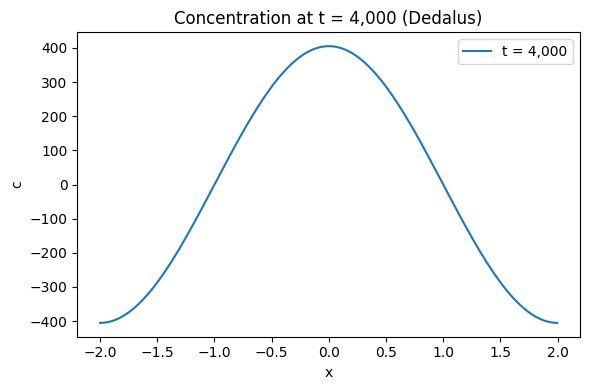

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging

# Dedalus setup
logger = logging.getLogger(__name__)
Nx = 1024
Lx = 2
kappa = 0.001
x_start = -Lx
x_end = Lx

# Create coordinate, basis, and distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64)
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)

# Set initial conditions
c = dist.Field(name='c', bases=x_basis)
w = 0.1
c.change_scales(1)
c['g'] = np.exp(-x**2 / w**2)

# Define operators and forcing
dx = lambda a: dedalus.Differentiate(a, xcoord)
f_x = dist.Field(bases=x_basis)
f_x['g'] = np.cos(np.pi * x / Lx)

# Specify problem
problem = dedalus.IVP([c], namespace=locals())
problem.add_equation("dt(c) - kappa * dx(dx(c)) = f_x")
timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

# Set simulation parameters
solver.stop_sim_time = 5000
timestep = 0.1

# Save data
c_save_all = []
t_save = []
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' % (solver.iteration, solver.sim_time, timestep))
    c.change_scales(1)
    c_save_all.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

# Convert saved data to arrays
c_save_all = np.array(c_save_all)
t_save = np.array(t_save)

# Find the index closest to t = 4000
t_target = 4000
t_idx = np.argmin(np.abs(t_save - t_target))
c_at_t = c_save_all[t_idx]

# Plot concentration at t = 4,000 for all x
plt.figure(figsize=(6, 4))
plt.plot(x, c_at_t, label=f't = 4,000')
plt.xlabel('x')
plt.ylabel('c')
plt.title(f'Concentration at t = 4,000 (Dedalus)')
plt.legend()
plt.tight_layout()
plt.show()

### 5.2 Variable diffusivity

In some applications of the diffusion equation, the diffusivity varies in space. This happens, for example, in the movement of pollution in groundwater flowing through soil of variable porosity, or the mixing of tracers due to turbulence in the ocean (which we will explore in detail in Project 2).

In the code cell below, write a Dedalus script that solves the following equation:

$$\partial_t c - \partial_x(\kappa (x) \partial_x c) = 0$$

where

$$\kappa(x)=\kappa_0(0.1 + tanh(x/0.1)+1)/2$$

and $\kappa_0=0.001$. It is fine to start by copying the code in the previous cell and changing the problem equation appropriately.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.1e+00/s


2024-12-16 09:34:24,935 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.1e+00/s


INFO:solvers:Simulation stop time reached.


2024-12-16 09:34:25,487 solvers 0/1 INFO :: Simulation stop time reached.


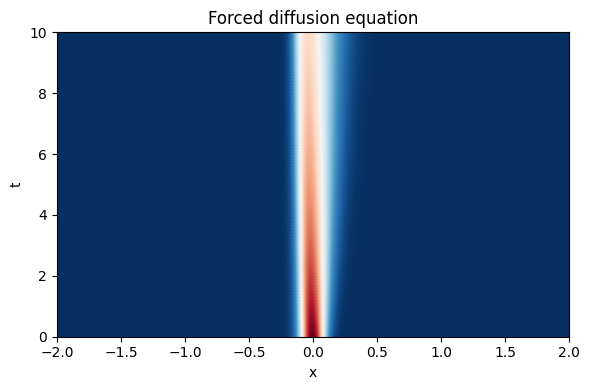

In [20]:
# Load the required packages (these were loaded above and are inluded here for completeness)
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# This script solves the forced diffusion equation with Dedlaus

# Set some parameters for the problem to be solved
Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
Lx = 2; # The domain size in x.  This should be large enough so that the solution goes to zero at the endpoints.
x_start=-Lx; x_end=Lx # The starting and ending bounds on x
kappa_0 = 0.001 # set the diffusivity

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)
kappa = dist.Field(name = 'kappa', bases = x_basis)
kappa['g'] = kappa_0 * (0.1 + np.tanh(x/0.1) + 1) * 0.5

# Set initial conditions
c = dist.Field(name='c', bases=x_basis)
w = 0.1 # Set the width of the initial Gaussian
c.change_scales(1) # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

# Specify the problem
problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
problem.add_equation("dt(c) - dx(kappa * dx(c)) = 0"); # Write out the equation to be solved

timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

solver.stop_sim_time = 10 # Stop at 10 simulation time units

# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0: # Every 500 timesteps, print a message to the screen with the progress
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_save), np.array(c_save), cmap='RdBu_r', shading='gouraud', rasterized=True)#, clim=(-1, 1))
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Forced diffusion equation')
plt.tight_layout()

Explore the behaviour of the solution as you vary the parameters associated with $\kappa(x)$. Comment on your observations below (~1 paragraph)

If κ gets 10 times larger, the new graph shows a different pattern, where the substance whose concentration is in question spreads in the $x$-direction more quickly than with the original κ. This indicates that the substance does not stay at $x = 0$ as long as it does with the original κ. When changing the denominator $0.1$ to a smaller value in $tanh(x/0.1)$, I can see higher concentrations closer to $x = 0$ for every $t$, as $tanh(x/n)$, where $n < 0.1$, reaches $1$ and $-1$ faster than $tanh(x/0.1)$ with an increasing and decreasing $x$, respectively.

## 6. Optional further investigations

* Try writing a Dedalus script to solve the 2D diffusion equation as an initial value problem.  You can look ahead to the the example at the end of the Project 2 notebook for some guidance (but remove the advection term). I would suggest using a Fourier/Fourier basis for this.

* Consider how you might go about discretizing a 2D diffusion equation using finite differences.  What form would the matrix M have?
